<a id='START'></a>

# Model Network
Create a linked ensemble of models to more accurately predict drug use

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

___

<a id='fit_model'></a>

## Custom functions

In [3]:
def plot_train_test_split_distrib(y_train, y_test):
    '''
    Quick, flawed function to plot distributions of drugs in training and testing splits
    '''
    train_test_split_distributions = pd.DataFrame(columns=['Train','Test'], index=y_train.columns)

    for column in y_train:
        df = y_train[column].value_counts()
        df2 = y_test[column].value_counts()

        train_pct = df.iloc[1] / df.iloc[0]
        test_pct  = df2.iloc[1] / df2.iloc[0]

        train_test_split_distributions.loc[column] = [train_pct, test_pct]
    fig = train_test_split_distributions.plot.bar(figsize=(14,3));
    plt.xticks(rotation=45, fontsize=14);
    return fig


In [4]:
def fit_model(model, model_features, model_response, model_test_inp, ground_truth):
    """
    Performs XGBoost Randomized Search for best model
    Inputs: model = XGBClassifier model, model_features = X_train, model_response = y_train, 
            model_test_input = X_test, ground_truth = y_test
    Returns best_model, confusion_matrix, tuple of roc_curve (fpr, tpr, thresholds)
    """
#     XGBoost param_grid
    param_grid = {
        'learning_rate': [0.005, 0.01, 0.02],
        'min_child_weight': [1, 5, 10],
        'min_delta_step': [1,3,9],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'booster': ['gbtree']
        }

    rSearchCV = RandomizedSearchCV(model, param_grid, n_iter=100, n_jobs=4, cv=5, scoring='roc_auc')
    rSearchCV.fit(model_features, model_response)
    
    model = rSearchCV.best_estimator_
    prediction = model.predict(model_test_inp)
    c_matrix = confusion_matrix(ground_truth, prediction)
    errors = prediction - ground_truth
    
    roc_auc = roc_auc_score(ground_truth, prediction)
    fpr, tpr, thresholds = roc_curve(ground_truth, prediction)
    roc_curves = (roc_auc, fpr, tpr, thresholds)
    print(model)
    print('Errors: \n',errors.value_counts())
    return (model, c_matrix, roc_curves)

___

<a id='toc'></a>

<a id=setup></a>

# Setup
Import data, split into training and testing sets.

## Import data from 03
Read ```./data/drugC_features.pkl```, ```./data/drugC_responses.pkl```, and ```./data/drugC_cohorts.pkl```.

In [5]:
df_features  = pd.read_pickle('./data/drugC_features.pkl')
df_responses = pd.read_pickle('./data/drugC_responses.pkl')

In [6]:
with open('./data/drugC_cohorts.pkl', 'rb') as handle:
    drug_cohorts = pickle.load(handle)
handle.close()

## Train-test split
Split into 80/20 sets., plot distributions of 

In [7]:
test_size    = .2
random_state = 40 #random.randint(1,100)

In [8]:
X_train, X_test, y_train, y_test = (train_test_split(df_features,
                                                     df_responses,
                                                     #stratify=df_responses,
                                                     test_size=test_size,
                                                     random_state=random_state,
                                                    ))

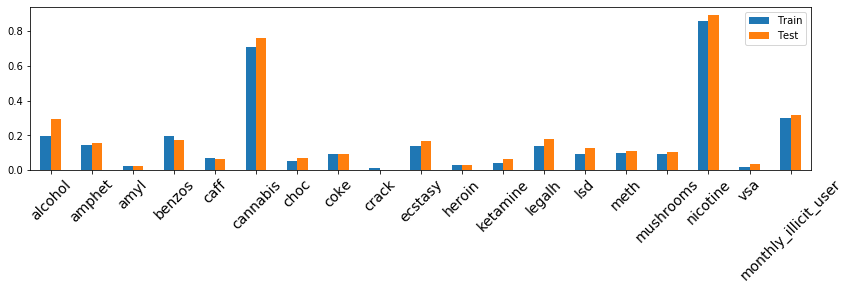

In [9]:
plot_train_test_split_distrib(y_train, y_test)

___


<a id='network_structure'></a>

# Network Structure
Describe network, initialize models.

Check drug cohorts (should be ```[0, 4]``` for monthly)

In [11]:
drug_cohorts

{'alcohol': [0, 4],
 'amphet': [0, 4],
 'amyl': [0, 4],
 'benzos': [0, 4],
 'caff': [0, 4],
 'cannabis': [0, 4],
 'choc': [0, 4],
 'coke': [0, 4],
 'crack': [0, 4],
 'ecstasy': [0, 4],
 'heroin': [0, 4],
 'ketamine': [0, 4],
 'legalh': [0, 4],
 'lsd': [0, 4],
 'meth': [0, 4],
 'mushrooms': [0, 4],
 'nicotine': [0, 4],
 'vsa': [0, 4]}

XGBoost models were chosen because of their power and lightweightness compared to other ensemble methods. As the end product is going to a be a web app, it is very important that the prediction time of the models are generally fast. 

In [12]:
models = {'alcohol': XGBClassifier(),
          'amphet': XGBClassifier(),
          'amyl': XGBClassifier(),
          'benzos': XGBClassifier(),
          'caff': XGBClassifier(),
          'cannabis': XGBClassifier(),
          'choc': XGBClassifier(),
          'coke': XGBClassifier(),
          'crack': XGBClassifier(),
          'ecstasy': XGBClassifier(),
          'heroin': XGBClassifier(),
          'ketamine': XGBClassifier(),
          'legalh': XGBClassifier(),
          'lsd': XGBClassifier(),
          'meth': XGBClassifier(),
          'mushrooms': XGBClassifier(),
          'nicotine': XGBClassifier(),
          'vsa': XGBClassifier(),
          'monthly_illicit_user': XGBClassifier(),
         }

# RandomForestClassifier(n_estimators=150,criterion='entropy',n_jobs=4)

___


<a id='first_level'></a>

# First level
```alcohol```, ```caff```, ```choc```, ```monthly_illicit_user```.

In [13]:
fitted_models_lvl1 = {}
c_matrices_lvl1 = {}
roc_curves_lvl1 = {}

## Train models

In [14]:
for drug in ['alcohol','caff','choc','monthly_illicit_user']:

    model_features = X_train
    model_response = y_train[drug]
    model_test_inp = X_test
    ground_truth = y_test[drug]
    #print(model_features.columns)

    fitted_models_lvl1[drug], c_matrices_lvl1[drug], roc_curves_lvl1[drug] = fit_model(models[drug], model_features, model_response, model_test_inp, ground_truth)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.005, max_delta_step=0, max_depth=4,
              min_child_weight=1, min_delta_step=3, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method=None, validate_parameters=False, verbosity=None)
Errors: 
 0    292
1     85
Name: alcohol, dtype: int64
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.005, max_delta_step=0, max_depth=4,
              min_chi

___


<a id='second_layer'></a>

# Second layer
Train ```amphet```, ```benzos```, ```cannabis```, ```ecstasy```, ```legalh```, and ```nicotine``` on X_train + ```monthly_illicit_user```.

In [15]:
fitted_models_lvl2 = {}
c_matrices_lvl2 = {}
roc_curves_lvl2 = {}

In [16]:
lvl2_drugs = ['amphet','benzos','cannabis','ecstasy','nicotine']

In [17]:
for drug in lvl2_drugs:
    model_features = X_train.assign(monthly_illicit_user = y_train['monthly_illicit_user'].values)
    model_response = y_train[drug]
    model_test_inp = X_test.assign(monthly_illicit_user = y_test['monthly_illicit_user'].values)
    ground_truth = y_test[drug]
    
    
    print('\n==============================================================\n')
    print('Drug:',drug)
    print(model_features.columns)

    try:
        fitted_models_lvl2[drug], c_matrices_lvl2[drug], roc_curves_lvl2[drug] = fit_model(models[drug], model_features, model_response, model_test_inp, ground_truth)
    except:
        print("Model for",drug,"already exists.")
        pass



Drug: amphet
Index(['age', 'education', 'nscore', 'escore', 'oscore', 'ascore', 'cscore',
       'impulsiveness', 'ss', 'monthly_illicit_user'],
      dtype='object')
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1.5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=5, min_delta_step=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method=None, validate_parameters=False, verbosity=None)
Errors: 
  0    332
 1     36
-1      9
Name: amphet, dtype: int64


Drug: benzos
Index(['age', 'education', 'nscore', 'escore', 'oscore', 'ascore', 'cscore',
       'impulsiveness', 'ss

# Third Layer
Train ```coke``` and ```meth``` models on ```X_train``` + ```monthly_illicit_user``` + ```lvl2_drugs```.

In [18]:
fitted_models_lvl3 = {}
c_matrices_lvl3 = {}
roc_curves_lvl3 = {}

In [19]:
lvl3_drugs = ['coke','meth']

In [20]:
for drug in lvl3_drugs:
    model_features = X_train.assign(monthly_illicit_user = y_train['monthly_illicit_user'].values)
    model_response = y_train[drug]
    model_test_inp = X_test.assign(monthly_illicit_user = y_test['monthly_illicit_user'].values)
    ground_truth = y_test[drug]
    
    # append results from lvl2 drugs
    for lvl2_drug in lvl2_drugs:
        model_features[lvl2_drug] = y_train[lvl2_drug]
        model_test_inp[lvl2_drug] = y_test[lvl2_drug]
    
    print('\n==============================================================\n')
    print('Drug:',drug)
    print(model_features.columns)

    try:
        fitted_models_lvl3[drug], c_matrices_lvl3[drug], roc_curves_lvl3[drug] = fit_model(models[drug], model_features, model_response, model_test_inp, ground_truth)
    except:
        print("Model for",drug,"already exists.")
        pass



Drug: coke
Index(['age', 'education', 'nscore', 'escore', 'oscore', 'ascore', 'cscore',
       'impulsiveness', 'ss', 'monthly_illicit_user', 'amphet', 'benzos',
       'cannabis', 'ecstasy', 'nicotine'],
      dtype='object')
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=0, max_depth=4,
              min_child_weight=5, min_delta_step=9, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method=None, validate_parameters=False, verbosity=None)
Errors: 
  0    346
-1     29
 1      2
Name: coke, dtype: int64


Drug: meth
Index(['age', 'education', 'nscore', 'escore', 'os

# Fourth Layer
Train the rest of the drugs on ```X_train``` + ```monthly_illicit_user``` + ```lvl2_drugs``` + ```lvl3_drugs```.

In [21]:
fitted_models_lvl4 = {}
c_matrices_lvl4 = {}
roc_curves_lvl4 = {}

In [22]:
lvl4_drugs = ['amyl','heroin','crack','ketamine','legalh','mushrooms','lsd','vsa']

In [23]:
for drug in lvl4_drugs:
    model_features = X_train.assign(monthly_illicit_user = y_train['monthly_illicit_user'].values)
    model_response = y_train[drug]
    model_test_inp = X_test.assign(monthly_illicit_user = y_test['monthly_illicit_user'].values)
    ground_truth = y_test[drug]
    
    # append results from lvl2 drugs
    for lvl2_drug in lvl2_drugs:
        model_features[lvl2_drug] = y_train[lvl2_drug]
        model_test_inp[lvl2_drug] = y_test[lvl2_drug]
    for lvl3_drug in lvl3_drugs:
        model_features[lvl3_drug] = y_train[lvl3_drug]
        model_test_inp[lvl3_drug] = y_test[lvl3_drug]
    
    print('\n==============================================================\n')
    print('Drug:',drug)
    print(model_features.columns)

    try:
        fitted_models_lvl4[drug], c_matrices_lvl4[drug], roc_curves_lvl4[drug] = fit_model(models[drug], model_features, model_response, model_test_inp, ground_truth)
    except:
        print("Model for",drug,"already exists.")
        pass



Drug: amyl
Index(['age', 'education', 'nscore', 'escore', 'oscore', 'ascore', 'cscore',
       'impulsiveness', 'ss', 'monthly_illicit_user', 'amphet', 'benzos',
       'cannabis', 'ecstasy', 'nicotine', 'coke', 'meth'],
      dtype='object')
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=10, min_delta_step=3, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method=None, validate_parameters=False, verbosity=None)
Errors: 
  0    369
-1      8
Name: amyl, dtype: int64


Drug: heroin
Index(['age', 'education', 'nscore', 'esc

___

# Model Inspection
Examine confusion matrices and ROC scores for each model.

Confusion matrices:

In [24]:
for drug in y_train.columns:
    print(drug)
    
    if drug in c_matrices_lvl1.keys():
        print("1")
        print (c_matrices_lvl1[drug])
    if drug in c_matrices_lvl2.keys():
        print("2")
        print (c_matrices_lvl2[drug])
    if drug in c_matrices_lvl3.keys():
        print("3")
        print (c_matrices_lvl3[drug])
    if drug in c_matrices_lvl4.keys():
        print("4")
        print (c_matrices_lvl4[drug])


alcohol
1
[[  0  85]
 [  0 292]]
amphet
2
[[291  36]
 [  9  41]]
amyl
4
[[369   0]
 [  8   0]]
benzos
2
[[319   3]
 [ 49   6]]
caff
1
[[  0  22]
 [  0 355]]
cannabis
2
[[170  44]
 [ 44 119]]
choc
1
[[  0  24]
 [  0 353]]
coke
3
[[344   2]
 [ 29   2]]
crack
4
[[376   0]
 [  1   0]]
ecstasy
2
[[323   0]
 [ 54   0]]
heroin
4
[[366   0]
 [ 11   0]]
ketamine
4
[[355   0]
 [ 22   0]]
legalh
4
[[319   1]
 [ 55   2]]
lsd
4
[[335   0]
 [ 42   0]]
meth
3
[[338   1]
 [ 37   1]]
mushrooms
4
[[342   0]
 [ 35   0]]
nicotine
2
[[136  63]
 [ 73 105]]
vsa
4
[[365   0]
 [ 12   0]]
monthly_illicit_user
1
[[267  19]
 [ 67  24]]


ROC scores for each model:

In [25]:
print('lvl1')
for drug in fitted_models_lvl1:
    print(drug, roc_curves_lvl1[drug][0])
print('lvl2')
for drug in lvl2_drugs:
    print(drug, roc_curves_lvl2[drug][0])
print('lvl3')
for drug in lvl3_drugs:
    print(drug, roc_curves_lvl3[drug][0])
print('lvl4')
for drug in lvl4_drugs:
    print(drug, roc_curves_lvl4[drug][0])

lvl1
alcohol 0.5
caff 0.5
choc 0.5
monthly_illicit_user 0.5986513486513486
lvl2
amphet 0.8549541284403669
benzos 0.5498870694522868
cannabis 0.7622269365288687
ecstasy 0.5
nicotine 0.636652362938287
lvl3
coke 0.5293678911057244
meth 0.5116829684831548
lvl4
amyl 0.5
heroin 0.5
crack 0.5
ketamine 0.5
legalh 0.5159813596491228
mushrooms 0.5
lsd 0.5
vsa 0.5


# Pickle the models
Save to ```./data/drugC_final_models.pkl``` and ```./data/drugC_final_roc_scores.pkl```.

Aggregate the models together from the ```fitted_models_lvl``` dictionaries

In [33]:
final_models = {}
final_roc_scores = {}
for drug in models:
    for level_set in [fitted_models_lvl1, fitted_models_lvl2, fitted_models_lvl3, fitted_models_lvl4]:
        if drug in level_set.keys():
            final_models[drug] = level_set[drug]
    for roc_set in [roc_curves_lvl1, roc_curves_lvl2, roc_curves_lvl3, roc_curves_lvl4]:
        if drug in roc_set.keys():
            final_roc_scores[drug] = roc_set[drug][0]


 Write each drug classifier to its own pickle (for Heroku)

In [49]:
for drug in final_models.keys():
    with open('./data/'+drug+'_xgb.pkl', 'wb') as handle:
        pickle.dump(final_models[drug], handle)
    handle.close()

Pickle the models_dict and the final ROC scores

In [41]:
with open('./data/drugC_final_models.pkl', 'wb') as handle:
    pickle.dump(final_models, handle)
handle.close()

In [36]:
with open('./data/drugC_final_roc_scores.pkl', 'wb') as handle:
    pickle.dump(final_roc_scores, handle)
handle.close()

# [&#x21b8; to Top](#START) 